In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
class LinearRegression:
    def __init__(self, optimizer="none", regularization="none", learning_rate=0.01, epochs=100, batch_size=None, alpha=0.1, verbose=False):
        self.optimizer = optimizer
        self.regularization = regularization
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.alpha = alpha
        self.verbose = verbose
        self.weights = None
        self.bias = None

    def loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)

    def y_prediction(self, X_train):
        return np.dot(X_train, self.weights) + self.bias

    def gradient(self, X_train, y_true):
        m = X_train.shape[0]
        y_pred = self.y_prediction(X_train)
        da = (2 / m) * np.dot(X_train.T, (y_pred - y_true))
        db = (2 / m) * np.sum(y_pred - y_true)

        # Apply regularization to the gradient
        if self.regularization == 'ridge':
            da += (2 * self.alpha / m) * self.weights  # Ridge regularization term
        elif self.regularization == 'lasso':
            da += (self.alpha / m) * np.sign(self.weights)  # Lasso regularization term

        return da, db

    def mini_batch_gradient_descent(self, X_train, y_true):
       m, n = X_train.shape
       indices = np.random.permutation(m)
       for i in range(0, m, self.batch_size):
        batch_indices = indices[i:i + self.batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        da, db = self.gradient(X_batch, y_batch)
        self.weights -= self.learning_rate * da
        self.bias -= self.learning_rate * db

    def stochastic_gradient_descent(self, X_train, y_true):
      m, n = X_train.shape
      indices = np.random.permutation(m)
      for i in indices:
          X_single = X_train[i:i + 1]
          y_single = y_train[i:i + 1]
          da, db = self.gradient(X_single, y_single)
          self.weights -= self.learning_rate * da
          self.bias -= self.learning_rate * db


    def fit(self, X_train, y_train, X_test, y_test):
        m, n = X_train.shape
        self.weights = np.random.randn(n) * 0.1
        self.bias = 0
        gradient_magnitudes = []
        mse_values = []
        mae_values = []
        r2_values = []

        for epoch in range(self.epochs):
            if self.optimizer == "mini_batch":
                self.mini_batch_gradient_descent(X_train, y_train)
            elif self.optimizer == "sgd":
                self.stochastic_gradient_descent(X_train, y_train)
            else:
              da, db = self.gradient(X_train, y_train)
              gradient_magnitudes.append(np.linalg.norm(da))
              self.weights -= self.learning_rate * da
              self.bias -= self.learning_rate * db

            y_pred = self.y_prediction(X_train)
            mse_values.append(self.mean_squared_error(y_train, y_pred))
            mae_values.append(self.mean_absolute_error(y_train, y_pred))
            r2_values.append(self.r2_score(y_train, y_pred))

            if self.verbose and epoch % 10 == 0:
                print(f"Epoch {epoch+1}: Loss = {self.loss(y_pred, y_train):.4f}")


        print("\nModel Evaluation Metrics on Test Data:")
        y_test_pred = self.y_prediction(X_test)
        self.evaluate_model(y_test, y_test_pred)
        self.plot_results(y_test, y_test_pred)
        self.plot_metric_curve(gradient_magnitudes, "Gradient Magnitude", "Gradient Magnitude vs Epochs")
        self.plot_metric_curve(mse_values, "MSE", "MSE vs Epochs")
        self.plot_metric_curve(mae_values, "MAE", "MAE vs Epochs")
        self.plot_metric_curve(r2_values, "R² Score", "R² Score vs Epochs")

    def mean_squared_error(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def mean_absolute_error(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def r2_score(self, y_true, y_pred):
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        return 1 - (ss_residual / ss_total)

    def evaluate_model(self, y_true, y_pred):
        metrics = {
            "MSE": self.mean_squared_error(y_true, y_pred),
            "MAE": self.mean_absolute_error(y_true, y_pred),
            "R² Score": self.r2_score(y_true, y_pred)
        }
        for key_train, value in metrics.items():
            print(f"{key_train}: {value:.4f}")

    def plot_results(self, y_true, y_pred):
        plt.scatter(range(len(y_true)), y_true, color='blue', label='True Values', alpha=0.7)
        plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.7)
        plt.title("True Value vs Predicted Value")
        plt.xlabel("Index")
        plt.ylabel("Values")
        plt.legend()
        plt.show()

    def plot_metric_curve(self, values, ylabel, title):
        plt.plot(range(len(values)), values, label=ylabel, color='blue')
        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid()
        plt.show()


In [17]:
def get_user_input():
    # Get user input for gradient descent type
    optimizer = input("Choose gradient descent method (vanilla, mini_batch, stochastic): ").strip().lower()
    if optimizer not in ['vanilla', 'mini_batch', 'stochastic']:
        raise ValueError("Invalid optimizer choice! Choose 'vanilla', 'mini_batch', or 'stochastic'.")

    # Get user input for regularization type
    regularization = input("Choose regularization method (none, ridge, lasso): ").strip().lower()
    if regularization not in ['none', 'ridge', 'lasso']:
        raise ValueError("Invalid regularization choice! Choose 'none', 'ridge', or 'lasso'.")

    # Get user input for alpha (regularization strength)
    alpha = None
    if regularization in ['ridge', 'lasso']:
        alpha = float(input("Enter regularization strength (alpha): ").strip())

    # Get user input for learning rate and number of epochs
    learning_rate = float(input("Enter learning rate: ").strip())
    epochs = int(input("Enter number of epochs: ").strip())

    # Get user input for batch size (for mini-batch and stochastic gradient descent)
    batch_size = None
    if optimizer == 'mini_batch':
        batch_size = int(input("Enter batch size for mini-batch gradient descent: ").strip())

    return optimizer, regularization, alpha, learning_rate, epochs, batch_size


def run_model_on_input(X_train, y_train):
    # Get the user inputs
    optimizer, regularization, alpha, learning_rate, epochs, batch_size = get_user_input()

    # Initialize the model with the selected options
    model = LinearRegression(
        optimizer=optimizer,
        regularization=regularization,
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=batch_size,
        alpha=alpha,
        verbose=False  # Set to True if you want verbose output for each epoch
    )

    # Fit the model on the dataset
    model.fit(X_train, y_train, X_test, y_test)

In [18]:
from google.colab import files
uploaded = files.upload()

Saving Admission_Predict.csv to Admission_Predict (2).csv


In [19]:
df=pd.read_csv("Admission_Predict.csv")
data_df=df.copy()
arr=np.array(data_df.drop('Chance of Admit ',axis=1))
arr=np.array(data_df.drop('Serial No.',axis=1))

mean_std_arr = np.vstack([np.mean(arr, axis=1), np.std(arr, axis=1)]).T

for i in range(len(arr)):
    arr = (arr - np.mean(arr, axis=0)) / np.std(arr, axis=0)
X = arr
total_entries = len(X)
split_index = int(0.8 * total_entries)
y= np.array(data_df['Chance of Admit '])  # extract the price column from data

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

320
320
80
80


Choose gradient descent method (vanilla, mini_batch, stochastic): stochastic
Choose regularization method (none, ridge, lasso): lasso
Enter regularization strength (alpha): 2
Enter learning rate: 0.01
Enter number of epochs: 300

Model Evaluation Metrics on Test Data:
MSE: 0.0015
MAE: 0.0311
R² Score: 0.9323


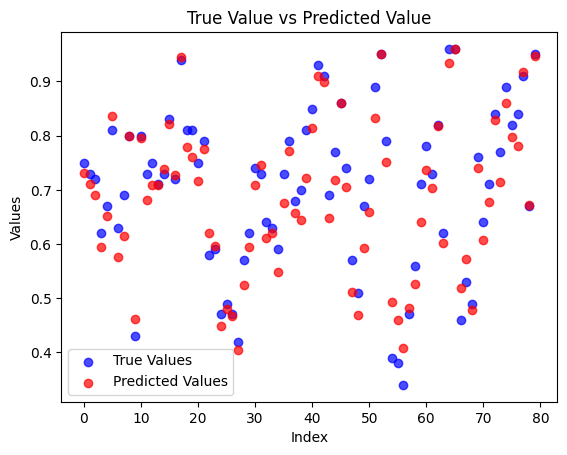

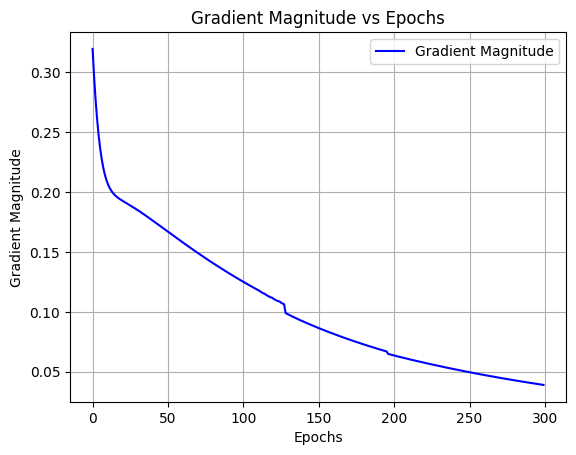

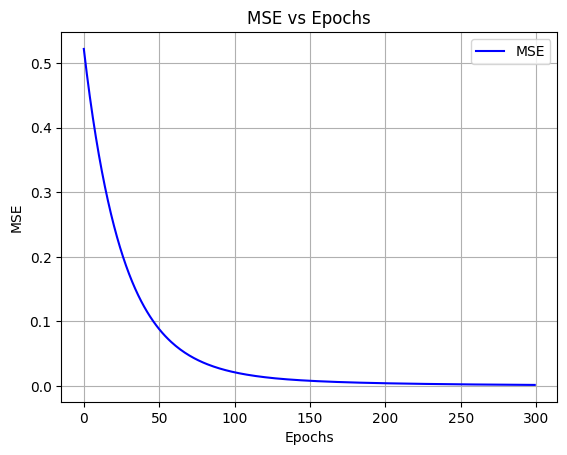

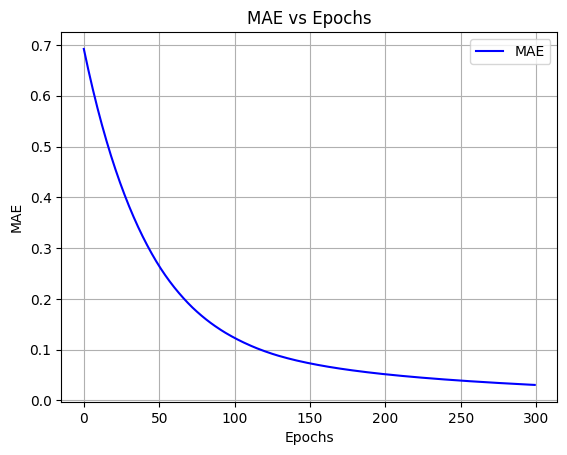

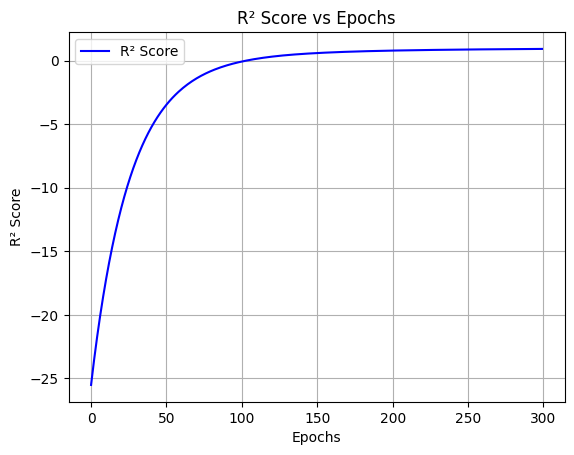

In [21]:
run_model_on_input(X_train,y_train)